<a href="https://colab.research.google.com/github/chrisfinan/GenAI/blob/main/HW6/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chris Finan

> 12/6/24

> HW 6

# 🎶 Description

* In this project, I will develop a music generation model using Transformers, specifically designed to generate new musical compositions in the style of Bach’s Cello Suites.

* The main objective here is to explore the application of Transformer models to music generation and understand the steps necessary for preparing, training, and evaluating such a model.

## 0. Transformer Utils, Import Statements, Mount Drive, and Parameters

In [1]:
#@title transformer_utils.py

import os
import pickle as pkl
import music21
import keras
import tensorflow as tf

from fractions import Fraction


def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes.append("START")
        durations.append("0.0")

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)
        print(f"{len(notes)} notes parsed")

    notes_list = []
    duration_list = []

    print(f"Building sequences of length {seq_len}")
    for i in range(len(notes) - seq_len):
        notes_list.append(" ".join(notes[i : (i + seq_len)]))
        duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pkl.dump(duration_list, f)

    return notes_list, duration_list


def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pkl.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pkl.load(f)
    return notes, durations


def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

In [2]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [3]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21
'''
from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)'''

'\nfrom transformer_utils import (\n    parse_midi_files,\n    load_parsed_files,\n    get_midi_note,\n    SinePositionEncoding,\n)'

In [4]:
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

# Paths
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/GenAI/bach_cello_suites.zip'
extract_to = '/content/'

# Extract the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')

Mounted at /content/drive


['.config', 'data', 'drive', 'sample_data']

In [5]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [6]:
# Load the data
file_list = glob.glob("/content/data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [7]:
parser = music21.converter

In [8]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [9]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7e7ec44556c0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 3/4>
    {0.0} <music21.note.Rest 2.5ql>
    {2.5} <music21.tempo.MetronomeMark Quarter=105>
    {2.5} <music21.chord.Chord G3>
{3.0} <music21.stream.Measure 2 offset=3.0>
    {0.0} <music21.chord.Chord G3>
    {0.5} <music21.chord.Chord D3>
    {1.0} <music21.chord.Chord G2>
    {1.5} <music21.chord.Chord B3>
    {1.75} <music21.chord.Chord C4>
    {2.0} <music21.chord.Chord D4>
    {2.25} <music21.chord.Chord C4>
    {2.5} <music21.chord.Chord B3>
    {2.75} <music21.chord.Chord A3>
{6.0} <music21.stream.Measure 3 offset=6.0>
    {0.0} <music21.chord.Chord B3>
    {0.5} <music21.chord.Chord D3>
    

In [10]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/data/cs2-6gig.mid


<ipython-input-10-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


735 notes parsed
2 Parsing /content/data/cs1-3cou.mid
1555 notes parsed
3 Parsing /content/data/cs6-5gav.mid
2361 notes parsed
4 Parsing /content/data/cs3-2all.mid
3098 notes parsed
5 Parsing /content/data/cs3-6gig.mid
4059 notes parsed
6 Parsing /content/data/cs4-1pre.mid
4876 notes parsed
7 Parsing /content/data/cs5-3cou.mid
5306 notes parsed
8 Parsing /content/data/cs2-1pre.mid
5944 notes parsed
9 Parsing /content/data/cs6-6gig.mid
7116 notes parsed
10 Parsing /content/data/cs2-2all.mid
7809 notes parsed
11 Parsing /content/data/cs4-6gig.mid
8780 notes parsed
12 Parsing /content/data/cs4-3cou.mid
9702 notes parsed
13 Parsing /content/data/cs4-5bou.mid
11026 notes parsed
14 Parsing /content/data/cs3-1pre.mid
12007 notes parsed
15 Parsing /content/data/cs4-2all.mid
13062 notes parsed
16 Parsing /content/data/cs3-5bou.mid
13943 notes parsed
17 Parsing /content/data/cs5-6gig.mid
14392 notes parsed
18 Parsing /content/data/cs6-4sar.mid
14727 notes parsed
19 Parsing /content/data/cs6-2all

In [11]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G3 E3 D3 E3 F3 D3 G3 E3 D3 E3 F3 D3 G3 E3 C#3 B-3 A3 G3 F3 E3 F2 A3 G3 F3 E3 C#3 D3 B-2 A2 G2 A2 F2 D2 A2 D3 E3 F3 D3 E-3 F3 G3 E-3 F3 D3 G3 A3 B-3 G3 A3 F3 E-3 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [12]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [13]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         2         2
         8         2
         4         2
         8         2
         5         2
         4         2
         2         2
         8         2
         4         2
         8         2
         5         2


In [14]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [15]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [16]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[18, 16,  5, ...,  2,  5,  8],
       [16,  5,  4, ...,  5,  8,  2],
       [ 5,  4,  5, ...,  8,  2,  5],
       ...,
       [ 3,  9,  7, ...,  5,  9,  7],
       [ 9,  7,  9, ...,  9,  7,  6],
       [ 7,  9,  2, ...,  7,  6,  9]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 3],
       [2, 2, 2, ..., 2, 3, 3],
       [2, 2, 2, ..., 3, 3, 8]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[16,  5,  4, ...,  5,  8,  2],
       [ 5,  4,  5, ...,  8,  2,  5],
       [ 4,  5, 18, ...,  2,  5,  4],
       ...,
       [ 9,  7,  9, ...,  9,  7,  6],
       [ 7,  9,  2, ...,  7,  6,  9],
       [ 9,  2,  4, ...,  6,  9,  3]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2,  2],
       [ 2,  2,  2, ...,  2,  2

## 4. Create the causal attention mask function <a name="causal"></a>

In [17]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 5. Create a Transformer Block layer <a name="transformer"></a>

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 6. Create the Token and Position Embedding <a name="embedder"></a>

In [19]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

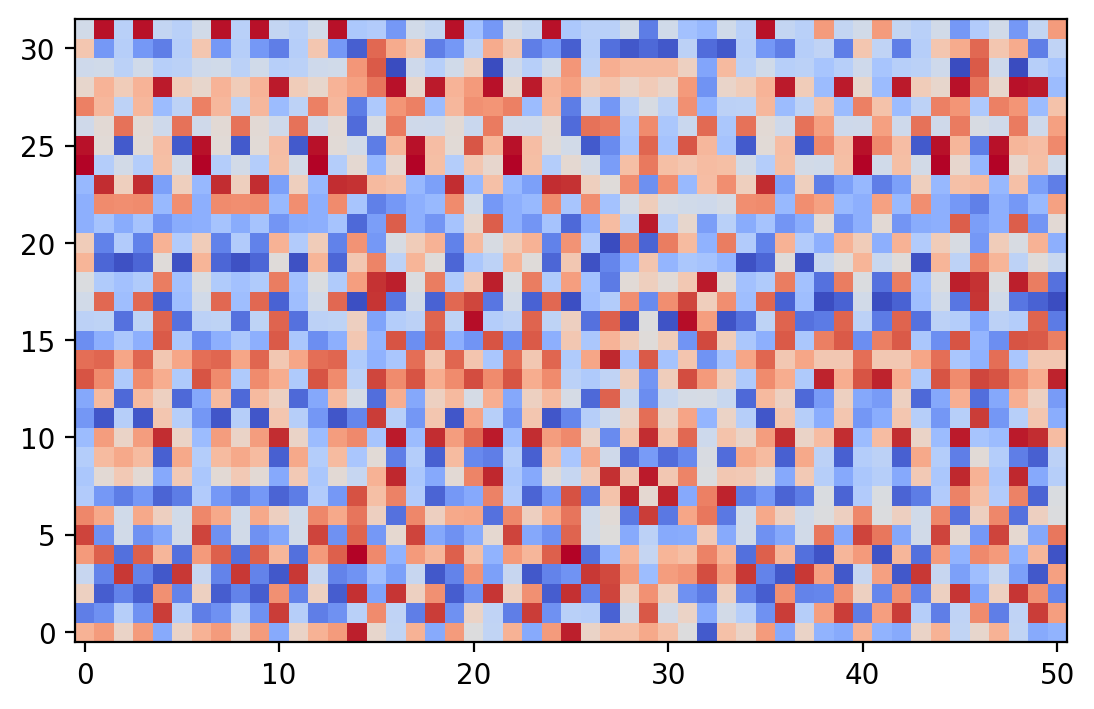

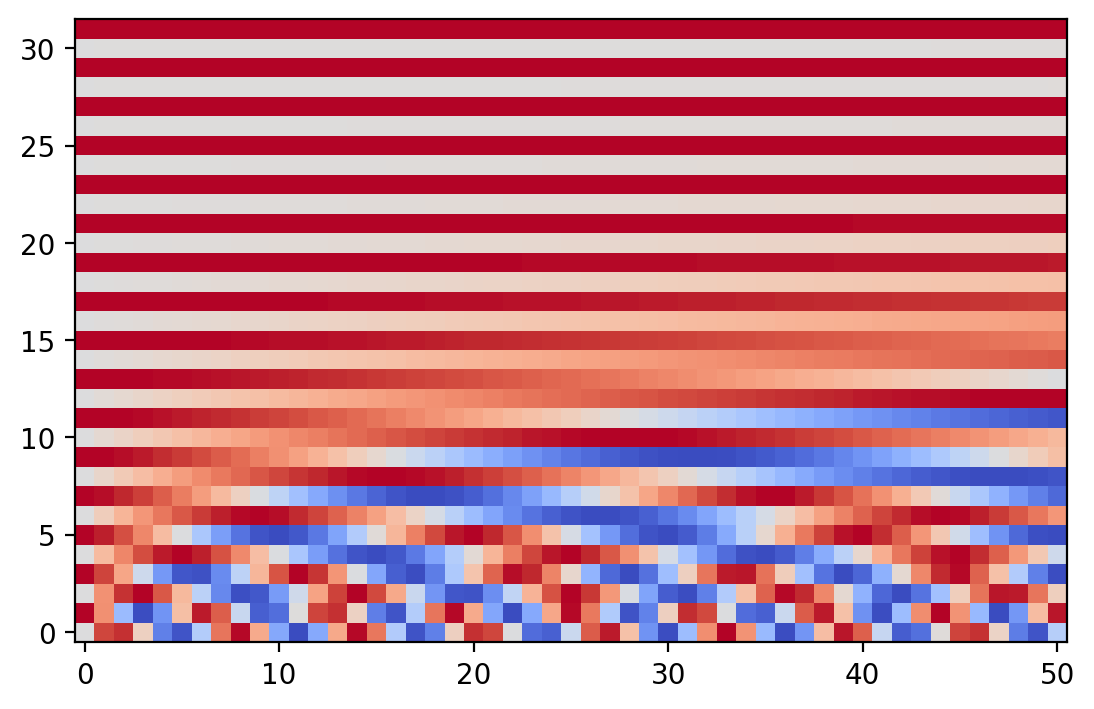

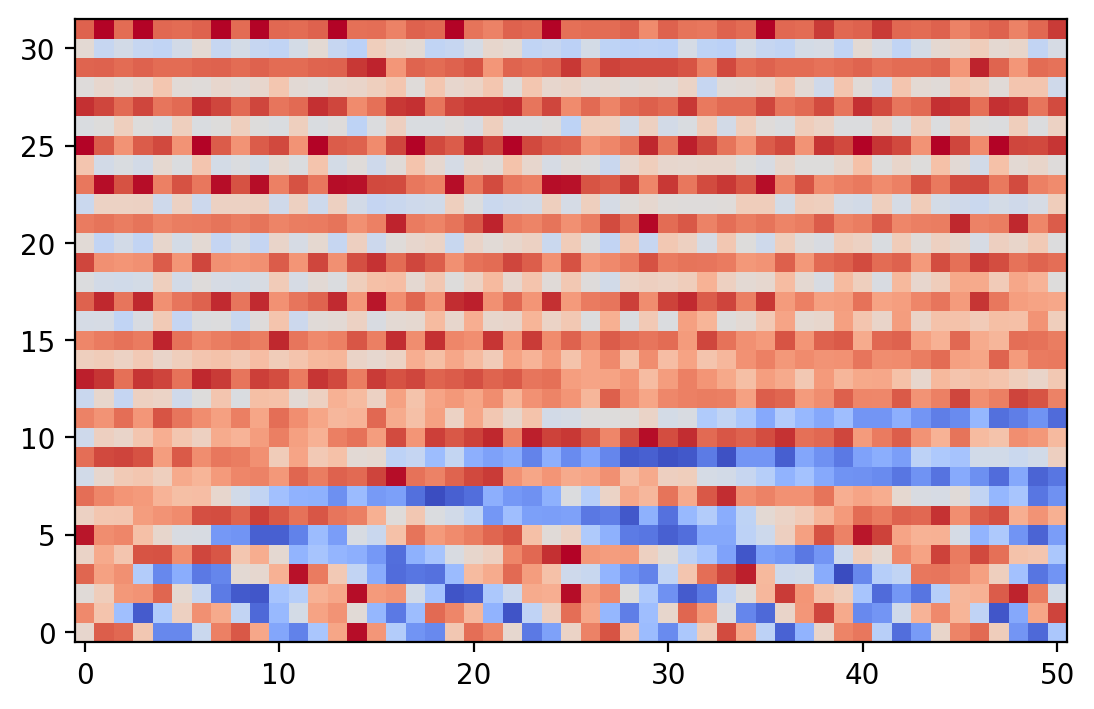

In [20]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 7. Build the Transformer model <a name="transformer_decoder"></a>

In [21]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          7,552 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          3,072 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 59)       │         15,163 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 24)       │          6,168 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the Transformer <a name="train"></a>

In [23]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info
'''
    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )'''

'\n    def on_epoch_end(self, epoch, logs=None):\n        info = self.generate(\n            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5\n        )\n        midi_stream = info[-1]["midi"].chordify()\n        print(info[-1]["prompt"])\n        #midi_stream.show()\n        midi_stream.write(\n            "midi",\n            fp=os.path.join(\n                "/content/output",\n                "output-" + str(epoch).zfill(4) + ".mid",\n            ),\n        )'

In [24]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [25]:
model.fit(
    ds,
    epochs=300,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - duration_outputs_loss: 1.2661 - loss: 4.8741 - note_outputs_loss: 3.6080
Epoch 2/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - duration_outputs_loss: 0.7440 - loss: 3.5142 - note_outputs_loss: 2.7702
Epoch 3/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - duration_outputs_loss: 0.6166 - loss: 3.2151 - note_outputs_loss: 2.5985
Epoch 4/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - duration_outputs_loss: 0.6059 - loss: 3.0777 - note_outputs_loss: 2.4717
Epoch 5/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - duration_outputs_loss: 0.5482 - loss: 2.9016 - note_outputs_loss: 2.3534
Epoch 6/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - duration_outputs_loss: 0.5022 - loss: 2.8729 - note_outputs_loss: 2.3706
Epoch 7/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - duration_outputs_loss: 0.5910 - loss: 2.9262 - note_outputs_loss: 2.3352
Epoch 8/300
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - duration_outputs_loss: 0.5394 - loss: 2

In [26]:
# Save the final model
model.save("/content/model.keras")

## 9. Generate music using the Transformer

In [27]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.9
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## 10. Write music to MIDI file and output it in My Drive

In [28]:
timestr = time.strftime("%Y%m%d-%H%M%S")
output_dir = "/content/drive/MyDrive/Colab Notebooks/GenAI/transformer_output"  # The directory to save the file

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

midi_stream.write(
    "midi",
    fp=os.path.join(
        output_dir,
        "output-" + timestr + ".mid",
    ),
)

'/content/drive/MyDrive/Colab Notebooks/GenAI/transformer_output/output-20241205-181549.mid'

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 11. Note probabilities

In [30]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

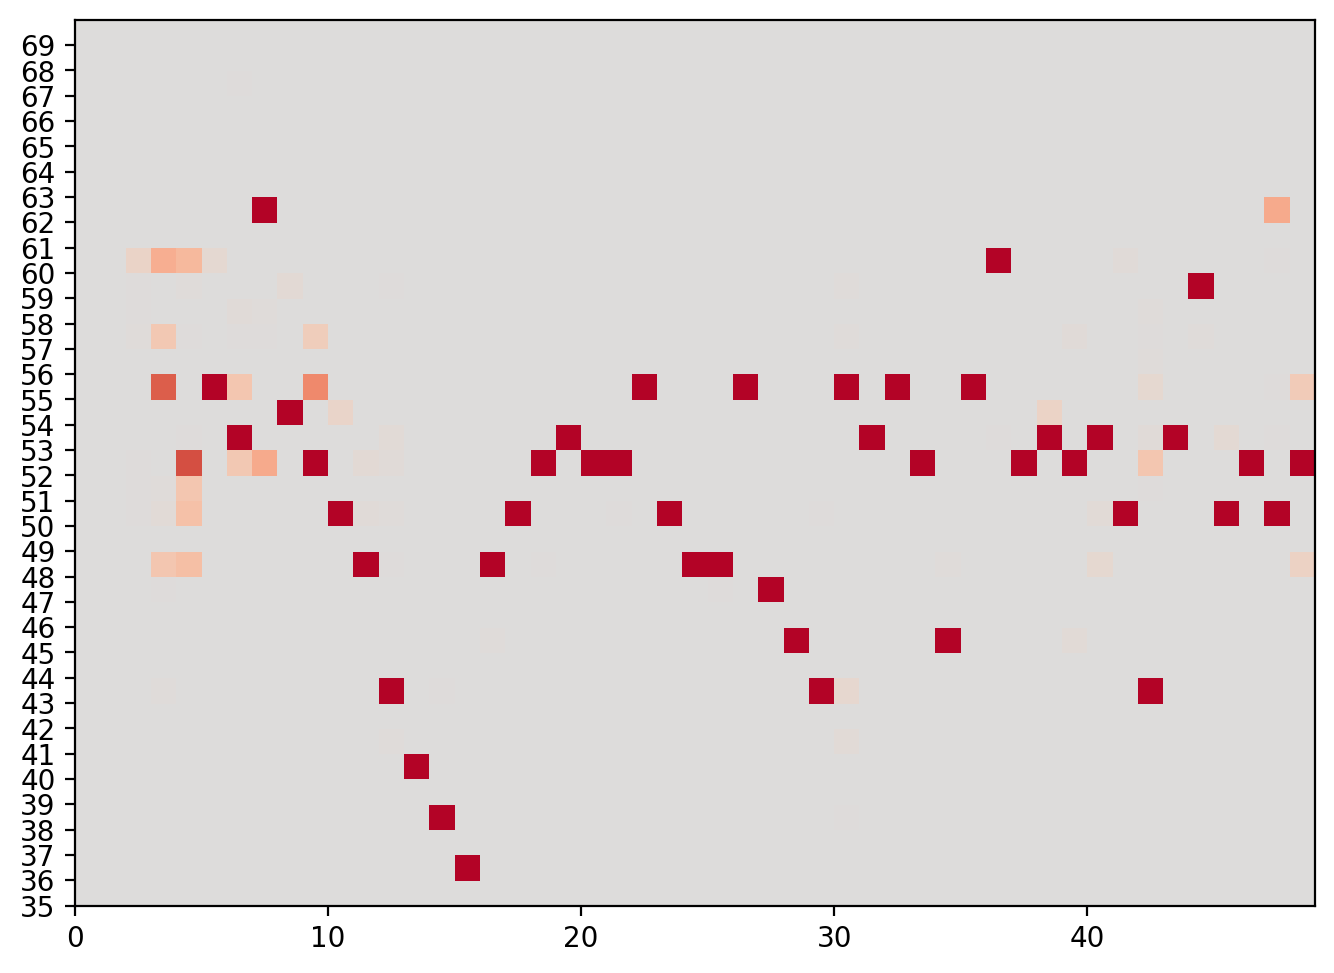

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## 12. Attention Plot

In [32]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [33]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

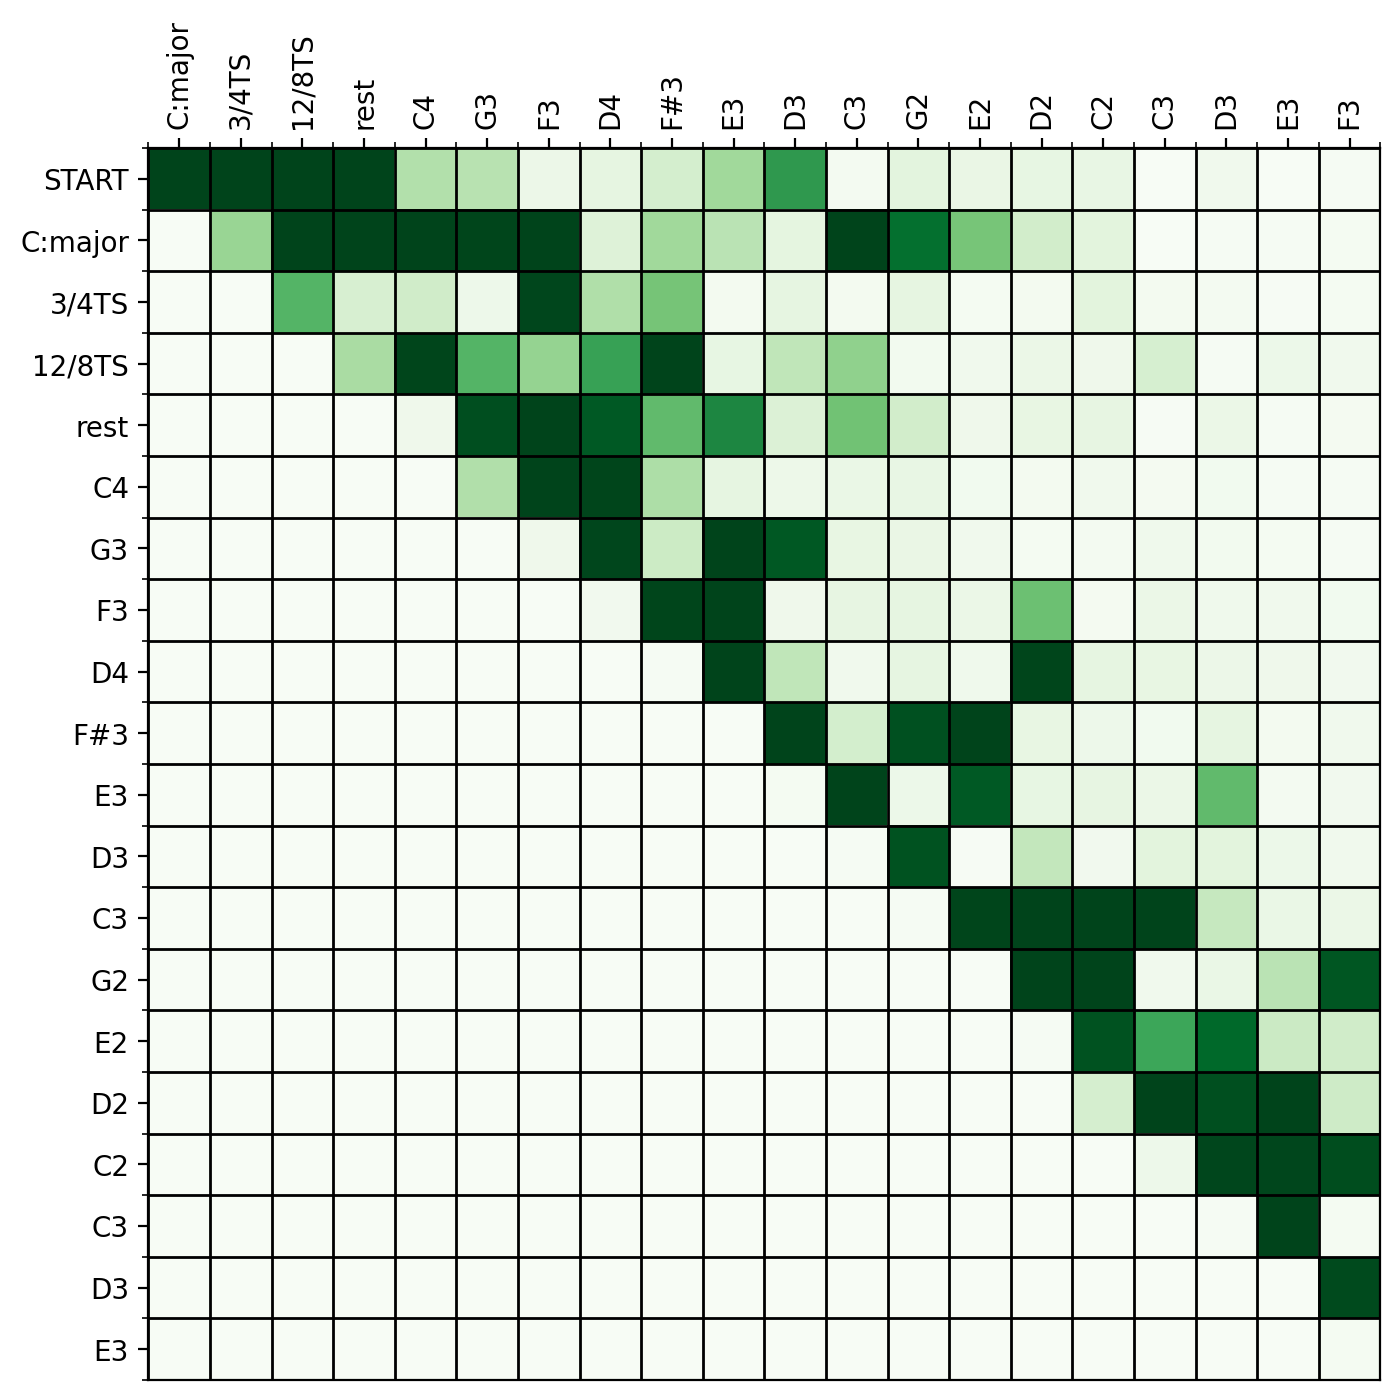

In [34]:
# As you can see, this plot looks very similar to the causal masking.
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()

## 13. Conclusion

I was honestly impressed when I heard the music that I was able to generate. They obviously weren't the best songs I've ever heard, but they were able to flow and make sense, which was a great improvement from generating text. One thing I found interesting was that every piece except the 300 epochs piece switched clefs midway through. This could be because this transformer can't generate multiple lines of music that play at the same time. I'm no expert, but starting with 3 rests in a row as a solo instrument seems interesting. A big thing that separates my generated music versus Bach's is the fact that most of mine do not have any ties or slurs. They make Bach's music seem as one piece and everything goes smoother and more natural. There are some unnatural note patterns or jumps in the music I generated. The two most interesting generated pieces were the 100 epochs with temperature 0.5 and the 300 epochs with temperature 0.9. The former was the only one to generate music with any ties in it and the latter was the only one to not switch from bass to treble clef. If someone were to guess what artist this was based off of, they might say Bach because there are small hints of the famous Cello Suite 1 in the generations. In my subjective evalution, the generator did an OK job generating the music in the style of Bach. There would need to be many more epochs to generate music indistinguishable from Bach.

Quantitative Metrics? Are there any such metrics to evaluate a model’s training performance?
* Yes. In this model specifically, we can take a look at the loss values as a quantitative evaluation during training. All of the loss values have decreased throughout, showing that the model has improved, but there are some portions in the middle where the loss values fluctuate.

Musical Quality? How can you determine if the generated music resembles Bach’s Cello Suites, both in structure and stylistic elements?
* The first way to determine this is by expert evaluation. There are scholars who study music and actual composers who try to compose like famous artists.
* The frequency and duration of each note can be analyzed to see if they match Bach. The way the music typically develops in a Bach piece is a more difficult way to analyze, but it can be done in something like the cello suites. Things like this can be done with the evaluation of a musicologist and by using tools, like a harmonic chart or a melody contour plot.
* Using AI, you can use a GAN discriminator or some form of classifier to try to distinguish the pieces.

References:
* https://github.com/bforoura/GenAI/blob/main/Module7/bach_transformer.ipynb
* https://github.com/bforoura/GenAI/blob/main/Module7/bach_cello_suites.zip